## Module 3 Homework

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import precision_score

### Data preprocessing

In [33]:
# Read as dataframe
df = pd.read_parquet("data/stocks_df_combined_2024_05_07.parquet.brotli")

# Filter only 25 years of data
df = df[df.Date >= "2000-01-01"]

In [34]:
# Volume; not using price as an absolute value
df["LN_Volume"] = np.where(df["Volume"] == 0, np.nan, np.log(df["Volume"]))

# Growth represented as relative price
GROWTH = [c for c in df.columns if c.startswith("growth_") and "future" not in c]

# Macro indicators
MACRO = ["gdppot_us_yoy", "gdppot_us_qoq", "cpi_core_yoy", "cpi_core_mom", "FEDFUNDS", "DGS1", "DGS5", "DGS10"]

# Technical indicators
TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc', 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext', 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix', 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo', 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk', 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr', 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase', 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine', 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']
TECHNICAL_PATTERNS = [c for c in df.columns if c.startswith("cdl")]

# User-defined
USER_DEFINED = ["SMA10", "SMA20", "growing_moving_average", "high_minus_low_relative", "volatility", "LN_Volume"]

# Unused
DROP_COLUMNS = ["Year", "Date", "index_x", "index_y", "index", "Quarter", "Adj Close_y", "Open", "High", "Low", "Close", "Adj Close_x"]

# Numerical features
NUMERICAL_FEATURES = GROWTH + MACRO + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + USER_DEFINED
df[NUMERICAL_FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 184 entries, growth_1d to LN_Volume
dtypes: float64(121), int32(62), int64(1)
memory usage: 214.6 MB


/Users/green/miniforge3/envs/stock-market-analytics-zoomcamp/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Question 1: Dummies on Month and Week-of-Month

Find the ABSOLUTE CORRELATION VALUE of the most correlated dummy <month-week_of_month> with the binary outcome variable `is_positive_growth_5d_future`?

In [35]:
# Cast type into a str
df["Month"] = df.Month.dt.strftime('%B')
df["Weekday"] = df.Weekday.astype(str)
df["Week_of_Month"] = ((df.Date.dt.day - 1) // 7).astype(str)
df["Month_Week_of_Month"] = df["Month"] + "_w" + df["Week_of_Month"]

# Create one-hot encoding for each category in each column
CATEGORICAL_FEATURES = ["Month", "Weekday", "Month_Week_of_Month", "Ticker", "ticker_type"]
dummies_df = pd.get_dummies(df[CATEGORICAL_FEATURES], dtype="int32")

# Dummies
DUMMIES = list(dummies_df.columns)
dummies_df[DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 115 entries, Month_April to ticker_type_US
dtypes: int32(115)
memory usage: 81.5 MB


In [36]:
# Concatenate dummies
df = pd.concat([df, dummies_df], axis=1).reset_index(drop=True)
df[NUMERICAL_FEATURES + DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182675 entries, 0 to 182674
Columns: 299 entries, growth_1d to ticker_type_US
dtypes: float64(121), int32(177), int64(1)
memory usage: 293.4 MB


In [37]:
# Correlation analysis: strength only (not direction)
TARGETS = [c for c in df.columns if "future" in c] # [growth_future_5d, is_positive_growth_5d_future]
abs(df[DUMMIES + TARGETS].corr()["is_positive_growth_5d_future"]).sort_values(ascending=False).head(20)

is_positive_growth_5d_future        1.000000
growth_future_5d                    0.668535
Month_Week_of_Month_September_w2    0.034537
Month_Week_of_Month_March_w3        0.026058
Month_Week_of_Month_October_w4      0.026023
Month_Week_of_Month_February_w2     0.024578
Month_Week_of_Month_May_w3          0.022264
Month_Week_of_Month_May_w0          0.022040
Month_October                       0.020550
Month_Week_of_Month_June_w2         0.019754
Month_Week_of_Month_December_w3     0.019270
Month_September                     0.019170
Month_Week_of_Month_December_w2     0.018295
Month_Week_of_Month_June_w0         0.017471
Month_Week_of_Month_October_w3      0.016331
ticker_type_INDIA                   0.015266
Month_November                      0.015222
Month_Week_of_Month_November_w3     0.014794
Month_Week_of_Month_October_w1      0.013996
Month_Week_of_Month_November_w2     0.013850
Name: is_positive_growth_5d_future, dtype: float64

### Question 2: Define new "hand" rules on macro and technical indicators variables

What is the precision score for the best of the NEW predictions (`pred3` or `pred4`), rounded to 3 digits after the comma?

In [7]:
# Helper functions
def temporal_split(df, validation_proportion=0.15, test_proportion=0.15):
    """
    Label split set of Dataframe via "Date" based on the given train validation and test proporation.
    """
    split_df = df.copy()
    
    train_proportion = 1 - validation_proportion - test_proportion
    min_date = split_df.Date.min()
    max_date = split_df.Date.max()
    date_range = max_date - min_date

    train_end_date = min_date + pd.Timedelta(days=date_range.days * train_proportion)
    validation_end_date = train_end_date + pd.Timedelta(days=1) + pd.Timedelta(days=date_range.days * validation_proportion)
    split_df["split"] = np.where(split_df.Date < train_end_date, "training", np.where(split_df.Date < validation_end_date, "validation", "test"))

    return split_df


def predict(df):
    """
    Naive prediction.
    """
    prediction_df = df.copy()

    prediction_df["pred0_manual_cci"] = (prediction_df.cci > 200).astype(int)
    prediction_df["pred1_manual_prev_g1"] = (prediction_df.growth_1d > 1).astype(int)
    prediction_df["pred2_manual_prev_g1_and_snp"] = ((prediction_df.growth_1d > 1) & (prediction_df.growth_snp500_1d > 1)).astype(int)
    prediction_df["pred3_manual_gdp_fastd"] = ((prediction_df.gdppot_us_yoy <= 0.027) & (prediction_df.fastd >= 0.251)).astype(int)
    prediction_df["pred4_manual_gdp_wti_oil"] = ((prediction_df.gdppot_us_yoy >= 0.027) & (prediction_df.growth_wti_oil_30d <= 1.005)).astype(int)

    return prediction_df

In [8]:
# Data splitting: ~70/15/15
df = temporal_split(df)

# Hand-rule preidiction 
df = predict(df)

# Label prediction
df["is_correct_pred0"] = df.pred0_manual_cci == df.is_positive_growth_5d_future
df["is_correct_pred1"] = df.pred1_manual_prev_g1 == df.is_positive_growth_5d_future
df["is_correct_pred2"] = df.pred2_manual_prev_g1_and_snp == df.is_positive_growth_5d_future
df["is_correct_pred3"] = df.pred3_manual_gdp_fastd == df.is_positive_growth_5d_future
df["is_correct_pred4"] = df.pred4_manual_gdp_wti_oil == df.is_positive_growth_5d_future

In [9]:
# No positive prediction on TEST dataset: overfitting on decision tree on TRAIN + VALIDATION dataset; can't use pred4
df[df.split == "test"]["pred4_manual_gdp_wti_oil"].value_counts()

pred4_manual_gdp_wti_oil
0    29829
Name: count, dtype: int64

In [10]:
# Precision score on pred3
print(df.loc[(df["split"] == "test") & (df["pred3_manual_gdp_fastd"] == 1), "is_correct_pred3"].value_counts(normalize=True))

is_correct_pred3
True     0.555295
False    0.444705
Name: proportion, dtype: float64


### Question 3: Unique correct predictions from a 10-levels deep Decision Tree Classifier (pred5_clf_10)

What is the total number of records in the TEST dataset when the new prediction `pred5_clf_10` is better than all 'hand' rules (`pred0`..`pred4`)?

In [11]:
# Helper function
def label_unique_prediction(x, uniquely_correct_column, target, other_prediction_columns):
    """
    Label a prediction when it is uniquely correct.
    """
    # Create conditions: is_correct and is_unique
    is_correct = x[uniquely_correct_column] == x[target]

    is_unique = True
    for c in other_prediction_columns:
        if (x[c] == x[target]):
            is_unique = False
            break

    # Validate conditions
    return 1 if is_correct and is_unique else 0

In [12]:
# Data splitting
features = NUMERICAL_FEATURES + DUMMIES
target = TARGETS[1] # binary classification

train_df = df.loc[df.split.isin(["training", "validation"]), [target] + features]
test_df = df.loc[df.split.isin(["test"]), [target] + features]

In [13]:
# Simple imputation
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [14]:
# Check training input/output
X_train = train_df[features]
y_train = train_df[target]

print(f"Faeture spaces: {X_train.shape}")
print(f"Target space: {y_train.shape}")

Faeture spaces: (152846, 299)
Target space: (152846,)


In [15]:
# Model training
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [16]:
# Check test input/output
X_test = test_df[features]
y_test = test_df[target]

print(f"Faeture spaces: {X_test.shape}")
print(f"Target space: {y_test.shape}")

Faeture spaces: (29829, 299)
Target space: (29829,)


In [17]:
# Model evaluation
y_pred = clf.predict(X_test)

prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.2%}")

Precision: 56.51%


In [18]:
# Build prediction
X_pred = df[features]
print(f"Faeture spaces: {X_pred.shape}")

y_pred = clf.predict(X_pred)
df["pred5_clf_10"] = y_pred

Faeture spaces: (182675, 299)


In [19]:
# Compare with hand-rule predictions
uniquely_correct_column = "pred5_clf_10"
other_prediction_columns = [c for c in df.columns if c.startswith("pred") and c != uniquely_correct_column]

# Manual
# df["only_pred5_is_correct"] = (df.pred5_clf_10 == df.is_positive_growth_5d_future) & (df.pred0_manual_cci != df.is_positive_growth_5d_future) & (df.pred1_manual_prev_g1 != df.is_positive_growth_5d_future) & (df.pred2_manual_prev_g1_and_snp != df.is_positive_growth_5d_future) & (df.pred3_manual_gdp_fastd != df.is_positive_growth_5d_future) & (df.pred4_manual_gdp_wti_oil != df.is_positive_growth_5d_future)

# Dynamic
df["only_pred5_is_correct"] = df.apply(label_unique_prediction, axis=1, args=(uniquely_correct_column, target, other_prediction_columns))

In [20]:
df[df.split == "test"]["only_pred5_is_correct"].value_counts()

only_pred5_is_correct
0    29828
1        1
Name: count, dtype: int64

### Question 4: Hyperparameter tuning for a Decision Tree

What is the optimal tree depth (from 1 to 20) for a DecisionTreeClassifier?

In [21]:
# Helper function
def print_tree(model, features, max_depth=3):
    """
    Display which feature that the "head" of a tree uses.
    """
    tree = export_text(model, feature_names=features, max_depth=max_depth)
    print(tree)

In [22]:
# List search space
max_depths = range(1, 21)

In [24]:
# Find the optimal depth using precision score on TEST set
possible_max_depths = list()
precisions = list()

for max_depth in max_depths:
    
    # Model training
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)

    # Model evaluation
    y_pred = clf.predict(X_test)
    prec = precision_score(y_test, y_pred)
    
    # Model summary
    print_tree(clf, features)
    print(f"Depth: {max_depth}\nPrecision on TEST set: {prec:.2%}")
    print('*' * 100)

    possible_max_depths.append(max_depth)
    precisions.append(prec)

|--- gdppot_us_yoy <= 0.03
|   |--- class: 1
|--- gdppot_us_yoy >  0.03
|   |--- class: 0

Depth: 1
Precision on TEST set: 55.52%
****************************************************************************************************
|--- gdppot_us_yoy <= 0.03
|   |--- fastd <= 0.25
|   |   |--- class: 0
|   |--- fastd >  0.25
|   |   |--- class: 1
|--- gdppot_us_yoy >  0.03
|   |--- growth_wti_oil_30d <= 1.00
|   |   |--- class: 1
|   |--- growth_wti_oil_30d >  1.00
|   |   |--- class: 0

Depth: 2
Precision on TEST set: 55.53%
****************************************************************************************************
|--- gdppot_us_yoy <= 0.03
|   |--- fastd <= 0.25
|   |   |--- growth_brent_oil_90d <= 1.06
|   |   |   |--- class: 0
|   |   |--- growth_brent_oil_90d >  1.06
|   |   |   |--- class: 1
|   |--- fastd >  0.25
|   |   |--- growth_gold_365d <= 1.53
|   |   |   |--- class: 1
|   |   |--- growth_gold_365d >  1.53
|   |   |   |--- class: 0
|--- gdppot_us_yoy >  0.03
|   

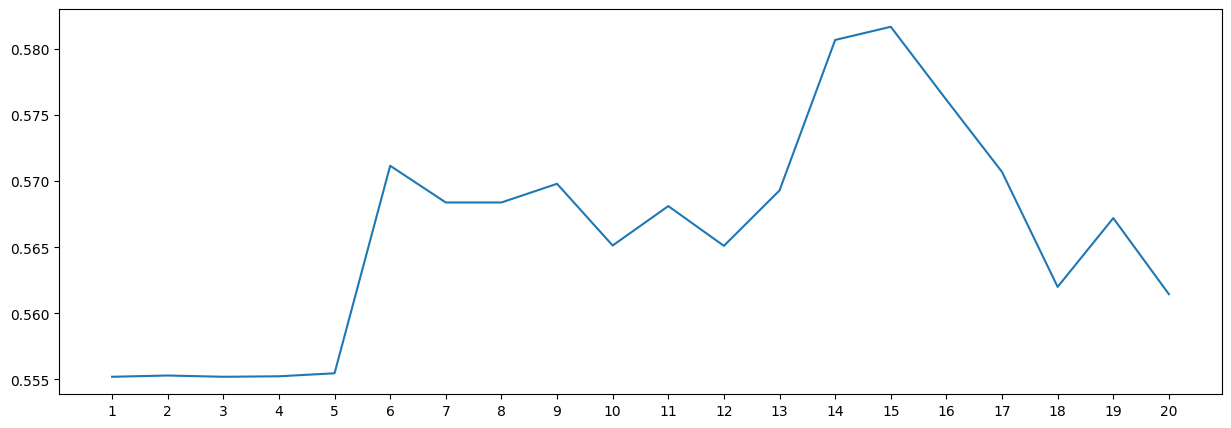

In [31]:
# Saturation point visualization: around 5 to 10 as 14 to 15 is likely to overfit with TEST set
plt.figure(figsize=(15, 5))
plt.plot(possible_max_depths, precisions)

plt.xticks(max_depths)
plt.show()

### [EXPLORATORY] Question 5: What data is missing?

Now that you have some insights from the correlation analysis and the Decision Trees regarding the most influential variables, suggest new indicators you would like to include in the dataset and explain why.

You can also propose something entirely different based on your intuition, but it should be relevant to the shared dataset of the largest Indian, EU, and US stocks. If you choose this approach, please specify the data source as well.

Ans: We saw a lot of macro technical indicators as one of the highest feature importance in in the lecture. In my opinion, we may include other commodity asset such as coal or silver. We can find those data from [Trading Economics](https://tradingeconomics.com/commodity) via API access or web scraping.

Moreover, we can add other date features such as `Quarter` and `Week_of_Year`. The reason is there may be some seasonality on stocks in a yearly basis.